# Session 4 —  Dostoevsky Character Analysis with NLP
## Measure 6: Character Graph emotion analysis



In this notebook we:
- Load and clean full texts of *Crime and Punishment* and *The Brothers Karamazov*.
- Use a character library of names and aliases to extract sentences mentioning each major character.
- Apply sentence embeddings (via `sentence-transformers`) and clustering (via `KMeans`) to group themes such as fear, regret, and personality traits.
- Run emotion classification (via Hugging Face `twitter-roberta-base-emotion`) to quantify feelings like joy, sadness, anger, and fear.
- Print emotion counts for each character to understand their psychological profile.
- Visualize results with `matplotlib` as grouped bar charts, showing how emotions are distributed across characters.

This workflow allows us to build interpretable profiles of Dostoevsky’s characters, highlighting their inner struggles and emotional landscapes.


In [6]:
import re
from typing import List, Dict
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# You may need to install this once in your environment:
# !pip install sentence-transformers

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
def load_book(filepath: str) -> str:
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()

    if 'CHAPTER I' in text:
        start = text.find('CHAPTER I')
        text = text[start:]
    elif '*** START OF' in text:
        start = text.find('*** START OF')
        text = text[start + 100:]

    if '*** END OF' in text:
        end = text.find('*** END OF')
        text = text[:end]
    elif 'End of Project Gutenberg' in text:
        end = text.find('End of Project Gutenberg')
        text = text[:end]

    return text.strip()

CP_text = load_book('../data/Crime-punishment.txt')
BK_text = load_book('../data/The-Brotherskaramazov.txt')

print(f"Wonderland characters: {len(CP_text):,}")
print(f"Looking-Glass characters: {len(BK_text):,}")


c:\Users\dimas\NLP_w2\applied-NLP-week4\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Wonderland characters: 1,224,428
Looking-Glass characters: 1,956,237


In [8]:
from character_library import CHARACTERS
from sklearn.cluster import KMeans
def split_sentences(text: str) -> List[str]:
    return re.split(r'(?<=[.!?]) +', text)
def get_character_sentences(text: str, aliases: List[str]) -> List[str]:
    sentences = split_sentences(text)
    results = []
    for s in sentences:
        for alias in aliases:
            if re.search(rf'\b{alias}\b', s, re.IGNORECASE):
                results.append(s)
                break
    return results
rask_sentences = get_character_sentences(CP_text, CHARACTERS["crime_and_punishment"]["Raskolnikov"])
print(len(rask_sentences), "sentences mentioning Raskolnikov")
embeddings = model.encode(rask_sentences)
labels = KMeans(n_clusters=5, random_state=42).fit_predict(embeddings)

921 sentences mentioning Raskolnikov


In [14]:
from transformers import pipeline

# Load the emotion model
emotion_analyzer = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-roberta-base-emotion",
    truncation=True,        # <-- important
    max_length=512          # <-- enforce max length
)

def analyze_emotions(sentences):
    emotions = []
    for s in sentences:
        # Truncate long sentences manually as a safeguard
        if len(s.split()) > 200:   # ~200 words ≈ 512 tokens
            s = " ".join(s.split()[:200])
        result = emotion_analyzer(s)[0]
        emotions.append(result['label'])
    return emotions

Device set to use cpu


In [10]:
from collections import Counter

def plot_character_emotions(character: str, sentences: List[str]):
    emotions = analyze_emotions(sentences)
    counts = Counter(emotions)
    plt.bar(counts.keys(), counts.values())
    plt.title(f"Emotions for {character}")
    plt.show()

In [12]:
from collections import Counter
import matplotlib.pyplot as plt

def summarize_character_emotions(book_text, character_name, aliases):
    # Extract sentences mentioning the character
    sentences = get_character_sentences(book_text, aliases)
    # Run emotion analysis
    emotions = analyze_emotions(sentences)
    # Count frequencies
    return Counter(emotions)

def analyze_and_visualize(book_text, character_dict, title="Character Profiles"):
    profiles = {}
    print("=== Emotion counts per character ===")
    for char, aliases in character_dict.items():
        counts = summarize_character_emotions(book_text, char, aliases)
        profiles[char] = counts
        print(f"{char}: {dict(counts)}")   # <-- print results here

    # Collect all possible emotion labels
    all_emotions = set()
    for counts in profiles.values():
        all_emotions.update(counts.keys())
    all_emotions = sorted(all_emotions)

    # Plot grouped bar chart
    x = range(len(all_emotions))
    width = 0.1
    plt.figure(figsize=(12,6))

    for i, (char, counts) in enumerate(profiles.items()):
        values = [counts.get(e, 0) for e in all_emotions]
        plt.bar([p + i*width for p in x], values, width=width, label=char)

    plt.xticks([p + width*len(profiles)/2 for p in x], all_emotions, rotation=45)
    plt.ylabel("Frequency")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

=== Emotion counts per character ===
Raskolnikov: {'joy': 242, 'sadness': 264, 'anger': 143, 'optimism': 272}
Sonia: {'anger': 41, 'sadness': 164, 'optimism': 74, 'joy': 74}
Marmeladov: {'joy': 11, 'sadness': 16, 'anger': 1, 'optimism': 15}
Katerina: {'sadness': 52, 'optimism': 54, 'joy': 56, 'anger': 19}
Dounia: {'anger': 75, 'joy': 92, 'sadness': 111, 'optimism': 95}
Razumihin: {'optimism': 97, 'sadness': 100, 'joy': 95, 'anger': 46}
Porfiry: {'sadness': 46, 'joy': 65, 'anger': 26, 'optimism': 46}
Svidrigailov: {}
Luzhin: {'optimism': 68, 'anger': 27, 'sadness': 46, 'joy': 89}
Pulcheria: {'sadness': 38, 'joy': 27, 'optimism': 38, 'anger': 15}
Lizaveta: {'optimism': 23, 'joy': 13, 'sadness': 16, 'anger': 2}
Alyona: {'joy': 11, 'anger': 2, 'optimism': 7, 'sadness': 5}
Zossimov: {'optimism': 27, 'sadness': 22, 'joy': 23, 'anger': 9}
Nikodim: {}


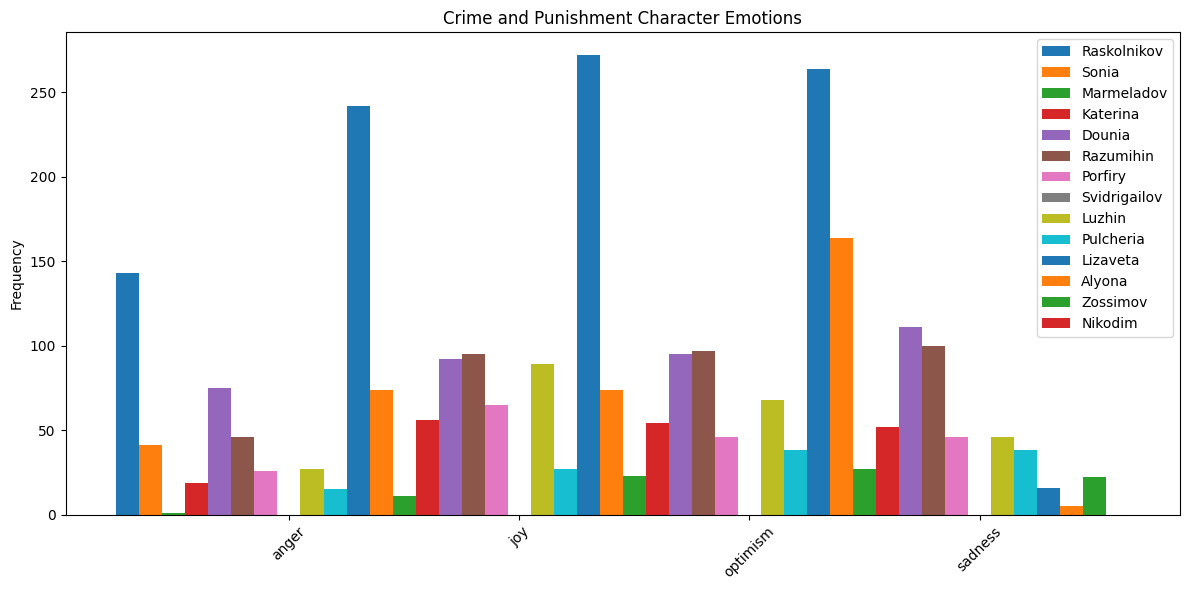

=== Emotion counts per character ===
Alyosha: {'optimism': 375, 'anger': 154, 'joy': 249, 'sadness': 332}
Ivan: {'anger': 103, 'optimism': 181, 'sadness': 177, 'joy': 191}
Dmitri: {'anger': 174, 'sadness': 265, 'optimism': 317, 'joy': 386}
Fyodor: {'sadness': 77, 'optimism': 84, 'joy': 95, 'anger': 31}
Grushenka: {'sadness': 78, 'joy': 120, 'optimism': 121, 'anger': 42}
Katerina: {'optimism': 78, 'anger': 27, 'sadness': 51, 'joy': 48}
Father Zosima: {}
Smerdyakov: {'joy': 126, 'optimism': 62, 'anger': 43, 'sadness': 104}
Rakitin: {'sadness': 36, 'joy': 71, 'optimism': 51, 'anger': 20}
Kolya: {}
Lise: {'optimism': 51, 'anger': 20, 'joy': 33, 'sadness': 37}
Madame Khokhlakov: {}
Ilusha: {'joy': 19, 'optimism': 62, 'sadness': 51, 'anger': 14}
Captain Sneigiryov: {}


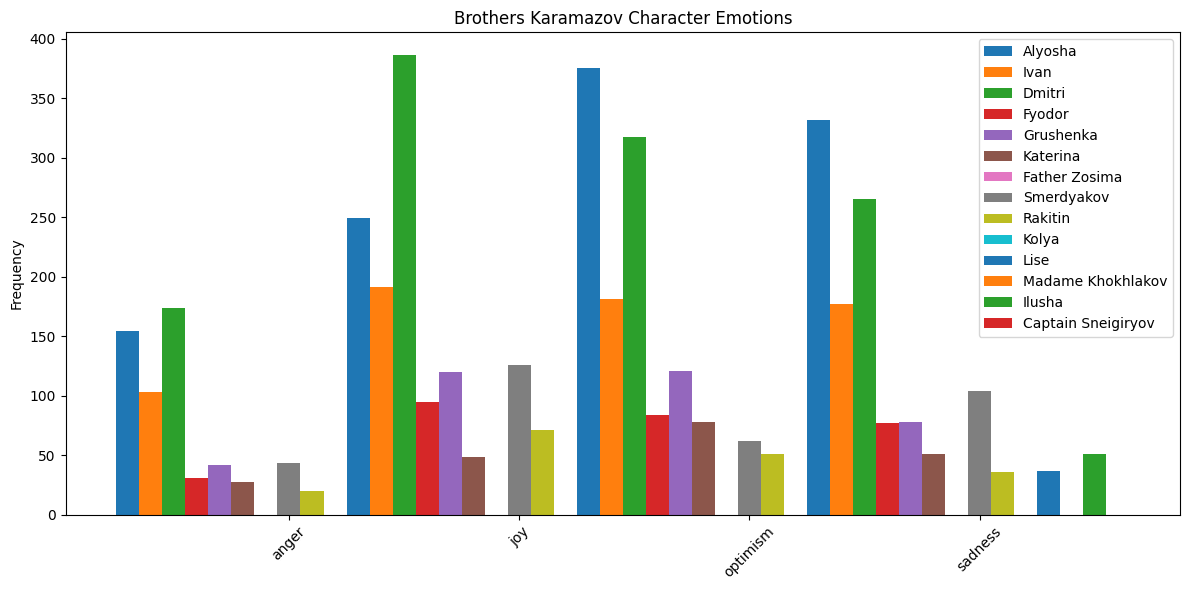

In [15]:
# Crime and Punishment
analyze_and_visualize(CP_text, CHARACTERS["crime_and_punishment"], 
                      title="Crime and Punishment Character Emotions")

# Brothers Karamazov
analyze_and_visualize(BK_text, CHARACTERS["brothers_karamazov"], 
                      title="Brothers Karamazov Character Emotions")

In [16]:
#ANGER ANALYSIS IS IT INTERNAL OR EXTERNAL?:

def classify_anger(sentences):
    internal_keywords =  {
        "myself","me","guilt","ashamed","regret","remorse","conscience","torment","suffering",
        "despair","misery","punishment","sin","crime","redemption","shame","weakness","cowardice",
        "self-loathing","madness","delirium","fever","dream","nightmare","soul","burden","curse","repent"
    }

    external_keywords =  {
        "you","him","her","father","mother","brother","sister","family","society","judge","police",
        "insult","quarrel","fight","enemy","hatred","contempt","scorn","injustice","betrayal",
        "accusation","blame","violence","murder","theft","greed","hypocrisy","corruption","oppression","tyranny"
    }


    internal, external = [], []

    for s in sentences:
        s_lower = s.lower()
        if any(word in s_lower for word in internal_keywords):
            internal.append(s)
        elif any(word in s_lower for word in external_keywords):
            external.append(s)
    return internal, external

def analyze_anger(book_text, character_name, aliases):
    # Extract sentences mentioning the character
    sentences = get_character_sentences(book_text, aliases)
    # Filter only those classified as anger
    emotions = analyze_emotions(sentences)
    anger_sentences = [s for s, e in zip(sentences, emotions) if e == "anger"]

    internal, external = classify_anger(anger_sentences)

    print(f"\n=== Anger Analysis for {character_name} ===")
    print(f"Internal anger: {len(internal)} examples")
    for ex in internal[:3]:   # show first 3 examples
        print(" -", ex.strip())

    print(f"External anger: {len(external)} examples")
    for ex in external[:3]:
        print(" -", ex.strip())

    return {"internal": internal, "external": external}

In [17]:
# Example for Raskolnikov
anger_profile = analyze_anger(CP_text, "Raskolnikov", CHARACTERS["crime_and_punishment"]["Raskolnikov"])


=== Anger Analysis for Raskolnikov ===
Internal anger: 91 examples
 - Finally, his meeting with the
saintly prostitute Sonia ultimately rescues him from
his own alter ego as she helps him to explore the path
that he must take to redemption.
    Perhaps most notable are the novel’s detailed
characters, including the evolution of the psychologi-
cal processes that occur in Raskolnikov’s criminal
mind.
 - While Raskolnikov’s narration is unreliable,


                          vii
                    introduction

the reactions of his friends and family not only help
to elucidate his character, but also the themes of
nihilism and existentialism.
    Rooted in the idea that people can develop a
utopia if they live for the purpose of enlightened self-
interest, nihilism is based on scientific fact and rea-
soning.
 - Like Raskolnikov, he torments him-
self to no end — similar to the existentialist role
model Sisyphus, who eternally rolls a boulder up a
hill, only to see it roll back down 